In [3]:
#IMPORTING REQUIRED LIBRARIES
import numpy as np
import pandas as pd
import itertools
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import classification_report

### Reading file from Local

In [4]:
# READING FILE PATH
#import os
os.chdir("C:\\Users\\acer\\MLP")

In [5]:
#READING FILE
data = pd.read_csv('train.csv')

In [5]:
#data

### Preprocessing

In [6]:
#Verifying Data for No Value in Labels
unlabelled_in_all = data[(data['Computer Science']!=1) & (data['Physics']!=1) & (data['Mathematics']!=1) & 
                            (data['Statistics']!=1) & (data['Quantitative Biology']!=1) & (data['Quantitative Finance']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(data)*100)

Percentage of unlabelled comments is  0.0


In [7]:
#Verifying Data for No Value in ABSTRACT
no_comment = data[data['ABSTRACT'].isnull()]
len(no_comment)

0

In [8]:
#Verifying Data for No Value in TITLE
no_comment = data[data['TITLE'].isnull()]
len(no_comment)

0

In [9]:
#Combinig the Title and Abstact to create new column for the classes prediction
data['TITLE_ABSTRACT']=data.TITLE+" "+data.ABSTRACT

In [10]:
#data['TITLE_ABSTRACT']

In [10]:
#Replacing words to their original formats
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [11]:
#Fitting ABSTRACT into Replacing Words Function
data['TITLE_ABSTRACT'] = data['TITLE_ABSTRACT'].map(lambda com : clean_text(com))

In [12]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [13]:
#Importing Libraries for Stopwords and Stemming
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [14]:
#def cleanHtml(sentence):
#    cleanr = re.compile('<.*?>')
#    cleantext = re.sub(cleanr, ' ', str(sentence))
#    return cleantext

#function to clean the word of any special characters

def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [15]:
#Applying more cleaning methods for converting text to lower, cleaning puctuations
data['TITLE_ABSTRACT'] = data['TITLE_ABSTRACT'].str.lower()
#data['ABSTRACT'] = data['ABSTRACT'].apply(cleanHtml)
data['TITLE_ABSTRACT'] = data['TITLE_ABSTRACT'].apply(cleanPunc)
data['TITLE_ABSTRACT'] = data['TITLE_ABSTRACT'].apply(keepAlpha)
#data.head()

In [16]:
#Stopwords Removal
#import nltk
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

#calling methods for removing stopwords

data['TITLE_ABSTRACT'] = data['TITLE_ABSTRACT'].apply(removeStopWords)
#data.head()

In [17]:
#STEMMING ABSTRACT
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

#calling methods for Stemming

data['TITLE_ABSTRACT'] = data['TITLE_ABSTRACT'].apply(stemming)
#data.head()

In [50]:
#Crearing lists with X and Y for further split

X = []
sentences = list(data["TITLE_ABSTRACT"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = data[["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]]

In [70]:
# Slicing data for testing the model
X = X[:5000]
y = y[:5000]

In [81]:
#pip install tax2vec

In [19]:
#importing Tensor Flow and Keras for Nueral Network models

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Activation, Embedding, GRU, Input, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from numpy import array, asarray, zeros

In [20]:
#Converting the words to Tokens for passing them to Models

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X1 = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 778

#Padding spaces at the end of the text

X1 = pad_sequences(X1, maxlen=maxlen)

### Tax2Vec Module Calling 

In [21]:
#Importing Tax2Vec and passing the data to get the hypernyms using Knowledge Graph
#We can use the values like closeness_centrality,mutual_info and pagerank values for heuristic parameter
#refined.txt can be downloaded from the link: https://github.com/SkBlaz/tax2vec/tree/master/data-concept

import tax2vec as t2v
from tax2vec.preprocessing import *
from tax2vec.models import *
tax2vec_instance = t2v.tax2vec(max_features=3, num_cpu=8, heuristic="rarest_terms", disambiguation_window=2, start_term_depth=3, knowledge_graph=True, mode="index_word", simple_clean=True, hyp="all", path="refined.txt")
X2 = tax2vec_instance.fit_transform(X)
X2 = X2.A

11-Oct-21 21:26:32 - Using rarest_terms heuristic.
11-Oct-21 21:26:32 - Constructing the taxonomy tree..
11-Oct-21 21:26:42 - Constructing local taxonomy...
11-Oct-21 21:27:23 - Looking up hypernyms using knowledge graph
11-Oct-21 21:45:19 - Selecting semantic terms..
11-Oct-21 21:46:49 - Saving hypernym distribution
11-Oct-21 21:46:49 - Folder structure insufficient!
11-Oct-21 21:47:02 - Constructing feature vectors..


... Computing weights for 3 semantic vectors ...


In [23]:
#X = X1    #Uncomment this line and comment the line below for runnig models without tax2vec

#Combing the New Features from Tax2vec with the input word tokens

X = np.concatenate((X1, X2), axis=1)
print(X.shape)
print(y.shape)

(20972, 781)
(20972, 6)


In [176]:
#print(X2)

In [24]:
#Creating embedding vectors using the glove file.

# Gloev file can be downloaded from this link: https://www.kaggle.com/danielwillgeorge/glove6b100dtxt

word_embeddings = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word_key = values[0]
        word_vector = np.array(values[1:], dtype='float32')
        word_embeddings[word_key] = word_vector
word_index = tokenizer.word_index
num_words = min(vocab_size, len(word_index)+1)
embedding_matrix = np.zeros((num_words, 100))
for word, idx in word_index.items():
    if idx < vocab_size:
        embedding_vector = word_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [25]:
#Splitting the dataset to train and test with 20 percent data for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [26]:
print(f'shape of the Training X data: {X_train.shape}')
print(f'shape of the targets: {y_train.shape}')
print(f'shape of the embedding_matrix: {embedding_matrix.shape}')

shape of the Training X data: (16777, 781)
shape of the targets: (16777, 6)
shape of the embedding_matrix: (35402, 100)


### LSTM

In [25]:
#Deffining embedding layer for building LSTM Model. Change the input size to input length specified in tokenization before running model without tax2vec

embedding_layer = tf.keras.layers.Embedding(input_dim=num_words, output_dim=100, weights=[embedding_matrix], input_length=781, trainable=False)
input_LSTM = tf.keras.Input(shape=(781,))

In [26]:
#Building LSTM Model wuth Activation layer as Relu and Sigmoid

model_LSTM = embedding_layer(input_LSTM)
model_LSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True))(model_LSTM)
model_LSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True))(model_LSTM)
model_LSTM = tf.keras.layers.GlobalMaxPooling1D()(model_LSTM)
model_LSTM = tf.keras.layers.Dense(64, activation='relu')(model_LSTM)
model_LSTM = tf.keras.layers.Dense(128, activation='relu')(model_LSTM)
model_LSTM = tf.keras.layers.Dropout(.2)(model_LSTM)
model_LSTM = tf.keras.layers.Dense(128, activation='relu')(model_LSTM)
output_LSTM = tf.keras.layers.Dense(6, activation='sigmoid')(model_LSTM)
model_LSTM = tf.keras.Model(inputs=input_LSTM, outputs=output_LSTM)
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
print(model_LSTM.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 781)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 781, 100)          3540200   
_________________________________________________________________
bidirectional (Bidirectional (None, 781, 200)          160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 781, 200)          240800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320  

In [120]:
#Fitting the model

history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=100, epochs= 3, validation_split=0.5) #without tax2vec

Epoch 1/3
84/84 [==============================] - 5952s 71s/step - loss: 0.4042 - accuracy: 0.5137 - val_loss: 0.2814 - val_accuracy: 0.7321
Epoch 2/3
84/84 [==============================] - 6127s 73s/step - loss: 0.2794 - accuracy: 0.7291 - val_loss: 0.2642 - val_accuracy: 0.7455
Epoch 3/3
84/84 [==============================] - 6125s 73s/step - loss: 0.2565 - accuracy: 0.7341 - val_loss: 0.2501 - val_accuracy: 0.7195


In [28]:
#Fitting the model

history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=100, epochs= 3, validation_split=0.5) #Rarest Terms with tax2vec for full data and KG = True

Epoch 1/3
84/84 [==============================] - 4828s 57s/step - loss: 0.3944 - accuracy: 0.5432 - val_loss: 0.2885 - val_accuracy: 0.7219
Epoch 2/3
84/84 [==============================] - 4972s 59s/step - loss: 0.2822 - accuracy: 0.7260 - val_loss: 0.2675 - val_accuracy: 0.7358
Epoch 3/3
84/84 [==============================] - 5123s 61s/step - loss: 0.2631 - accuracy: 0.7353 - val_loss: 0.2536 - val_accuracy: 0.7453


In [29]:
#Running the model for Test Data

predicted_output_LSTM = model_LSTM.predict(X_test)

In [30]:
#Converting the output to data frame 

predicted_output_LSTM = pd.DataFrame(predicted_output_LSTM)
predicted_output_LSTM.columns = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [123]:
predicted_output_LSTM #without tax2vec

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0.634572,0.107091,0.019861,0.494041,0.084276,0.013437
1,0.571306,0.279225,0.071898,0.219353,0.036678,0.011829
2,0.819896,0.053338,0.034325,0.319396,0.008858,0.002772
3,0.015471,0.960975,0.041821,0.005156,0.004168,0.000410
4,0.721151,0.014691,0.108521,0.674562,0.005486,0.003597
...,...,...,...,...,...,...
4190,0.807658,0.022510,0.114762,0.376054,0.003025,0.002136
4191,0.654040,0.123969,0.024980,0.450137,0.095094,0.015678
4192,0.024701,0.136459,0.917490,0.017412,0.000438,0.000849
4193,0.005799,0.990763,0.003441,0.001221,0.001683,0.000037


In [31]:
predicted_output_LSTM #with tax2vec Rarest Terms full data and KG = True

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0.758541,0.116572,0.031516,0.272788,0.064737,0.007393
1,0.613170,0.285315,0.141341,0.228191,0.076791,0.017322
2,0.795208,0.085882,0.082450,0.215874,0.020441,0.003199
3,0.011351,0.964706,0.039683,0.005806,0.003682,0.000658
4,0.810027,0.038871,0.092210,0.445313,0.021830,0.008558
...,...,...,...,...,...,...
4190,0.822180,0.056401,0.093984,0.266422,0.014271,0.003291
4191,0.754019,0.132712,0.033432,0.249145,0.078403,0.007746
4192,0.014544,0.078121,0.952936,0.004732,0.000128,0.000180
4193,0.003283,0.994533,0.003567,0.000944,0.000917,0.000056


In [32]:
#Setting the threshold value to converted the predicted output to one hot encoding

k = predicted_output_LSTM.shape
for index in range(k[0]):
    for u in list(predicted_output_LSTM.columns):
        if predicted_output_LSTM[u][index] <0.5:
            predicted_output_LSTM[u][index] = 0
        else:
            predicted_output_LSTM[u][index] = 1

In [33]:
import matplotlib.pyplot as plt

print("Loss\n",history_LSTM.history['loss'])
print("Validation Loss\n",history_LSTM.history['val_loss'])
print("Accuracy",history_LSTM.history['accuracy'])
print("Validation Accuracy",history_LSTM.history['val_accuracy'])

Loss
 [0.3943849503993988, 0.2821998596191406, 0.2630557417869568]
Validation Loss
 [0.2884587347507477, 0.26752644777297974, 0.25355368852615356]
Accuracy [0.5431568622589111, 0.7260372042655945, 0.735336184501648]
Validation Accuracy [0.7218977212905884, 0.7358445525169373, 0.7452616691589355]


########################   Loss  #########################




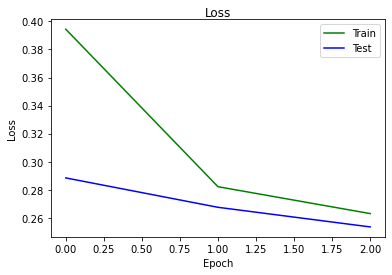

########################   Accuracy  #########################




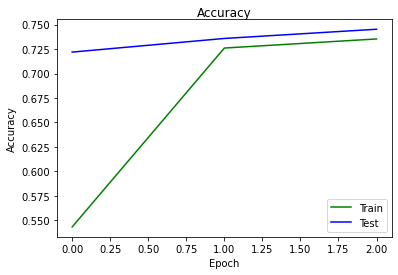

In [34]:
# Loss 

print("########################   Loss  #########################\n\n")
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_LSTM.history['loss'], color='green')
plt.plot(history_LSTM.history['val_loss'], color='blue')
plt.legend(['Train', 'Test'], loc='upper right')
plt.title('Loss', pad=-50)
plt.show()

# Accuracy

print("########################   Accuracy  #########################\n\n")
plt.figure()
plt.plot(history_LSTM.history['accuracy'], color='green')
plt.plot(history_LSTM.history['val_accuracy'], color='blue')
plt.title('Accuracy', pad=-75)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='lower right')

plt.show()

In [35]:
#Confusion matrix with the evaluation metrics like Precision, Recall and f1Score

print(classification_report(y_test, predicted_output_LSTM)) #with Rarest Terms, tax2vec for full data and KG = True

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1692
           1       0.85      0.79      0.82      1226
           2       0.87      0.61      0.72      1150
           3       0.76      0.22      0.34      1069
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00        45

   micro avg       0.80      0.62      0.70      5304
   macro avg       0.54      0.41      0.44      5304
weighted avg       0.78      0.62      0.66      5304
 samples avg       0.77      0.68      0.70      5304



In [125]:
#Confusion matrix with the evaluation metrics like Precision, Recall and f1Score

print(classification_report(y_test, predicted_output_LSTM)) #without tax2vec

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1692
           1       0.83      0.80      0.82      1226
           2       0.88      0.56      0.69      1150
           3       0.66      0.53      0.59      1069
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00        45

   micro avg       0.78      0.67      0.72      5304
   macro avg       0.52      0.45      0.48      5304
weighted avg       0.76      0.67      0.71      5304
 samples avg       0.75      0.71      0.71      5304



### GRU

In [27]:
#Deffining embedding layer for building GRU Model. Change the input size to input length specified in tokenization before running model without tax2vec
#Building GRU Model wuth Activation layer as Relu and Sigmoid

embedding_layer = tf.keras.layers.Embedding(input_dim=num_words, output_dim=100, weights=[embedding_matrix], input_length=781, trainable=False)
input_GRU = tf.keras.Input(shape=(781,))
model_GRU = embedding_layer(input_GRU)
model_GRU = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, return_sequences=True))(model_GRU)
model_GRU = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, return_sequences=True))(model_GRU)
model_GRU = tf.keras.layers.GlobalMaxPooling1D()(model_GRU)
model_GRU = tf.keras.layers.Dense(64, activation='relu')(model_GRU)
model_GRU = tf.keras.layers.Dense(128, activation='relu')(model_GRU)
model_GRU = tf.keras.layers.Dropout(.2)(model_GRU)
model_GRU = tf.keras.layers.Dense(128, activation='relu')(model_GRU)
output_GRU = tf.keras.layers.Dense(6, activation='sigmoid')(model_GRU)
model_GRU = tf.keras.Model(inputs=input_GRU, outputs=output_GRU)
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
print(model_GRU.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 781)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 781, 100)          3540200   
_________________________________________________________________
bidirectional (Bidirectional (None, 781, 200)          121200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 781, 200)          181200    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320  

In [128]:
#Fitting the model

history_GRU = model_GRU.fit(X_train, y_train, batch_size=100, epochs= 3, validation_split=0.5) #without tax2vec

Epoch 1/3
84/84 [==============================] - 6526s 78s/step - loss: 0.3690 - accuracy: 0.5990 - val_loss: 0.2742 - val_accuracy: 0.7357
Epoch 2/3
84/84 [==============================] - 6537s 78s/step - loss: 0.2680 - accuracy: 0.7431 - val_loss: 0.2493 - val_accuracy: 0.7527
Epoch 3/3
84/84 [==============================] - 6638s 79s/step - loss: 0.2375 - accuracy: 0.7393 - val_loss: 0.2273 - val_accuracy: 0.7548


In [29]:
#Fitting the model

history_GRU = model_GRU.fit(X_train, y_train, batch_size=100, epochs= 3, validation_split=0.5)  #with Rarest Terms, tax2vec for full data and KG = True

Epoch 1/3
84/84 [==============================] - 4522s 54s/step - loss: 0.3900 - accuracy: 0.5639 - val_loss: 0.2829 - val_accuracy: 0.7143
Epoch 2/3
84/84 [==============================] - 4590s 55s/step - loss: 0.2599 - accuracy: 0.7352 - val_loss: 0.2416 - val_accuracy: 0.7490
Epoch 3/3
84/84 [==============================] - 4654s 56s/step - loss: 0.2344 - accuracy: 0.7332 - val_loss: 0.2241 - val_accuracy: 0.7418


In [30]:
#Running the model for Test Data

predicted_output_GRU = model_GRU.predict(X_test)

In [31]:
#Converting the output to data frame 

predicted_output_GRU = pd.DataFrame(predicted_output_GRU)
predicted_output_GRU.columns = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [32]:
#Setting the threshold value to converted the predicted output to one hot encoding

k = predicted_output_GRU.shape
for index in range(k[0]):
    for u in list(predicted_output_GRU.columns):
        if predicted_output_GRU[u][index] <0.5:
            predicted_output_GRU[u][index] = 0
        else:
            predicted_output_GRU[u][index] = 1

In [115]:
import matplotlib.pyplot as plt

print("Loss\n",history_GRU.history['loss'])
print("Validation Loss\n",history_GRU.history['val_loss'])
print("Accuracy",history_GRU.history['accuracy'])
print("Validation Accuracy",history_GRU.history['val_accuracy'])

Loss
 [0.3520265817642212, 0.2438070923089981, 0.21969833970069885]
Validation Loss
 [0.25498053431510925, 0.23526136577129364, 0.22058074176311493]
Accuracy [0.6187410354614258, 0.7432045936584473, 0.7383166551589966]
Validation Accuracy [0.753486692905426, 0.7244009971618652, 0.7052091956138611]


########################   Loss  #########################




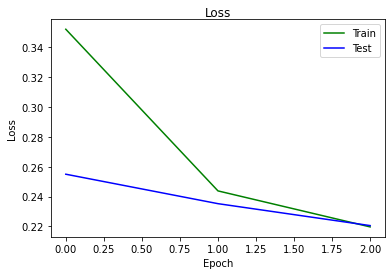

########################   Accuracy  #########################




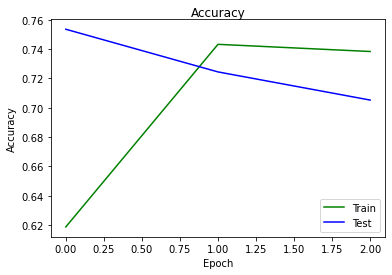

In [116]:
#Loss 

print("########################   Loss  #########################\n\n")
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_GRU.history['loss'], color='green')
plt.plot(history_GRU.history['val_loss'], color='blue')
plt.legend(['Train', 'Test'], loc='upper right')
plt.title('Loss', pad=-50)
plt.show()

# Accuracy

print("########################   Accuracy  #########################\n\n")
plt.figure()
plt.plot(history_GRU.history['accuracy'], color='green')
plt.plot(history_GRU.history['val_accuracy'], color='blue')
plt.title('Accuracy', pad=-75)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='lower right')

plt.show()

In [132]:
#Confusion matrix with the evaluation metrics like Precision, Recall and f1Score

print(classification_report(y_test, predicted_output_GRU)) #without tax2vec for full data

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1692
           1       0.87      0.82      0.85      1226
           2       0.80      0.73      0.76      1150
           3       0.77      0.50      0.61      1069
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00        45

   micro avg       0.80      0.72      0.76      5304
   macro avg       0.54      0.49      0.51      5304
weighted avg       0.78      0.72      0.74      5304
 samples avg       0.80      0.76      0.76      5304



In [33]:
#Confusion matrix with the evaluation metrics like Precision, Recall and f1Score

print(classification_report(y_test, predicted_output_GRU)) #with Rarest Terms, tax2vec for full data and KG = True

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      1692
           1       0.89      0.79      0.84      1226
           2       0.82      0.70      0.75      1150
           3       0.75      0.65      0.69      1069
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00        45

   micro avg       0.80      0.74      0.77      5304
   macro avg       0.54      0.50      0.52      5304
weighted avg       0.77      0.74      0.75      5304
 samples avg       0.79      0.77      0.77      5304



### RNN

In [34]:
#Deffining embedding layer for building RNN Model. Change the input size to input length specified in tokenization before running model without tax2vec
#Building RNN Model wuth Activation layer as Relu and Sigmoid

embedding_layer = tf.keras.layers.Embedding(input_dim=num_words, output_dim=100, weights=[embedding_matrix], input_length=781, trainable=False)
input_RNN = tf.keras.Input(shape=(781,))
model_RNN = embedding_layer(input_RNN)
model_RNN = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(100, return_sequences=True))(model_RNN)
model_RNN = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(100, return_sequences=True))(model_RNN)
model_RNN = tf.keras.layers.GlobalMaxPooling1D()(model_RNN)
model_RNN = tf.keras.layers.Dense(64, activation='relu')(model_RNN)
model_RNN = tf.keras.layers.Dense(128, activation='relu')(model_RNN)
model_RNN = tf.keras.layers.Dropout(.2)(model_RNN)
model_RNN = tf.keras.layers.Dense(128, activation='relu')(model_RNN)
output_RNN = tf.keras.layers.Dense(6, activation='sigmoid')(model_RNN)
model_RNN = tf.keras.Model(inputs=input_RNN, outputs=output_RNN)
model_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
print(model_RNN.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 781)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 781, 100)          3540200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 781, 200)          40200     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 781, 200)          60200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                12864     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320

In [173]:
#Fitting the model

history_RNN = model_RNN.fit(X_train, y_train, batch_size=100, epochs= 3, validation_split=0.5) #without tax2vec

Epoch 1/3
84/84 [==============================] - 1886s 22s/step - loss: 0.4034 - accuracy: 0.5212 - val_loss: 0.3075 - val_accuracy: 0.6983
Epoch 2/3
84/84 [==============================] - 1887s 23s/step - loss: 0.2934 - accuracy: 0.7191 - val_loss: 0.2703 - val_accuracy: 0.7414
Epoch 3/3
84/84 [==============================] - 1887s 23s/step - loss: 0.2621 - accuracy: 0.7389 - val_loss: 0.2549 - val_accuracy: 0.7225


In [36]:
#Fitting the model

history_RNN = model_RNN.fit(X_train, y_train, batch_size=100, epochs= 3, validation_split=0.5) #with tax2vec Rarest Terms for full data and KG = True

Epoch 1/3
84/84 [==============================] - 937s 11s/step - loss: 0.4249 - accuracy: 0.4704 - val_loss: 0.2936 - val_accuracy: 0.7128
Epoch 2/3
84/84 [==============================] - 927s 11s/step - loss: 0.2890 - accuracy: 0.7228 - val_loss: 0.2683 - val_accuracy: 0.7416
Epoch 3/3
84/84 [==============================] - 1136s 14s/step - loss: 0.2624 - accuracy: 0.7493 - val_loss: 0.2591 - val_accuracy: 0.7419


In [37]:
#Running the model for Test Data

predicted_output_RNN = model_RNN.predict(X_test)

In [38]:
#Converting the output to data frame 

predicted_output_RNN = pd.DataFrame(predicted_output_RNN)
predicted_output_RNN.columns = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [39]:
predicted_output_RNN #with Rarest Terms tax2vec for full data and KG = True

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0.845928,0.029727,0.013243,0.425567,0.022562,0.003659
1,0.667830,0.140438,0.046860,0.356978,0.066937,0.011827
2,0.767792,0.047841,0.095252,0.298981,0.022878,0.005436
3,0.013438,0.876987,0.241084,0.010720,0.008103,0.002674
4,0.739911,0.020331,0.152674,0.505885,0.012397,0.006500
...,...,...,...,...,...,...
4190,0.762101,0.030123,0.121030,0.419452,0.017364,0.006809
4191,0.768946,0.088866,0.045007,0.264393,0.052290,0.009226
4192,0.048745,0.032672,0.968564,0.028694,0.000848,0.001807
4193,0.015445,0.984309,0.008992,0.004425,0.013812,0.000642


In [176]:
predicted_output_RNN #without tax2vec

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0.806555,0.058828,0.026660,0.461407,0.039692,0.005814
1,0.382746,0.282128,0.132580,0.377392,0.037364,0.012428
2,0.623785,0.035840,0.179455,0.496040,0.009532,0.004876
3,0.014587,0.866918,0.219215,0.012474,0.007842,0.001310
4,0.722532,0.018277,0.131575,0.570688,0.012022,0.006569
...,...,...,...,...,...,...
4190,0.616824,0.028610,0.248866,0.615175,0.014910,0.011783
4191,0.778641,0.089775,0.051744,0.380690,0.067286,0.017176
4192,0.054102,0.043350,0.943069,0.049088,0.002276,0.003537
4193,0.018421,0.975477,0.019648,0.013530,0.014711,0.001313


In [40]:
#Setting the threshold value to converted the predicted output to one hot encoding

k = predicted_output_RNN.shape
for index in range(k[0]):
    for u in list(predicted_output_RNN.columns):
        if predicted_output_RNN[u][index] <0.5:
            predicted_output_RNN[u][index] = 0
        else:
            predicted_output_RNN[u][index] = 1

Loss
 [0.4103924632072449, 0.28968074917793274, 0.2659970223903656]
Validation Loss
 [0.30101242661476135, 0.28632673621177673, 0.26059287786483765]
Accuracy [0.5015498399734497, 0.7209108471870422, 0.7440391182899475]
Validation Accuracy [0.7096197605133057, 0.7199904918670654, 0.7474073171615601]
########################   Loss  #########################




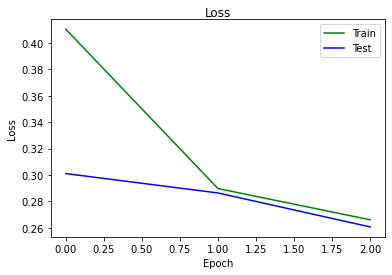

########################   Accuracy  #########################




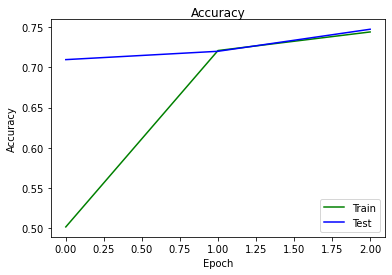

In [30]:
import matplotlib.pyplot as plt

print("Loss\n",history_RNN.history['loss'])
print("Validation Loss\n",history_RNN.history['val_loss'])
print("Accuracy",history_RNN.history['accuracy'])
print("Validation Accuracy",history_RNN.history['val_accuracy'])

#Loss 

print("########################   Loss  #########################\n\n")
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_RNN.history['loss'], color='green')
plt.plot(history_RNN.history['val_loss'], color='blue')
plt.legend(['Train', 'Test'], loc='upper right')
plt.title('Loss', pad=-50)
plt.show()

# Accuracy

print("########################   Accuracy  #########################\n\n")
plt.figure()
plt.plot(history_RNN.history['accuracy'], color='green')
plt.plot(history_RNN.history['val_accuracy'], color='blue')
plt.title('Accuracy', pad=-75)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='lower right')

plt.show()

In [41]:
#Confusion matrix with the evaluation metrics like Precision, Recall and f1Score

print(classification_report(y_test, predicted_output_RNN)) #with Rarest terms tax2vec for full data and KG = True

              precision    recall  f1-score   support

           0       0.69      0.92      0.79      1692
           1       0.93      0.70      0.80      1226
           2       0.82      0.66      0.73      1150
           3       0.69      0.46      0.55      1069
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00        45

   micro avg       0.76      0.69      0.72      5304
   macro avg       0.52      0.46      0.48      5304
weighted avg       0.75      0.69      0.71      5304
 samples avg       0.75      0.72      0.72      5304



In [178]:
#Confusion matrix with the evaluation metrics like Precision, Recall and f1Score

print(classification_report(y_test, predicted_output_RNN)) #without tax2vec

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1692
           1       0.90      0.75      0.82      1226
           2       0.82      0.70      0.75      1150
           3       0.61      0.70      0.65      1069
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00        45

   micro avg       0.75      0.74      0.74      5304
   macro avg       0.51      0.50      0.50      5304
weighted avg       0.74      0.74      0.73      5304
 samples avg       0.74      0.76      0.73      5304



### DNN

In [42]:
#Defining DNN Model. Change the input size to input length specified in tokenization before running model without tax2vec
#Building DNN Model wuth Activation layer as Relu and Sigmoid

model_DNN = tf.keras.models.Sequential()
model_DNN.add(tf.keras.Input(shape=(781,)))
model_DNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_DNN.add(tf.keras.layers.Dense(64, activation='relu'))
model_DNN.add(tf.keras.layers.Dense(128, activation='relu'))
model_DNN.add(tf.keras.layers.Dense(64, activation='relu'))
model_DNN.add(tf.keras.layers.Dense(6, activation='sigmoid'))
model_DNN.output_shape
model_DNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
print(model_DNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                25024     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
Total params: 44,102
Trainable params: 44,102
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
#Fitting the model

history_DNN = model_DNN.fit(X_train, y_train, batch_size=100, epochs= 3, validation_split=0.5) #with Rarest Terms, tax2vec for full data and KG = True

Epoch 1/3
84/84 [==============================] - 1s 11ms/step - loss: 5.6566 - accuracy: 0.2775 - val_loss: 0.8330 - val_accuracy: 0.2754
Epoch 2/3
84/84 [==============================] - 1s 9ms/step - loss: 0.6791 - accuracy: 0.2942 - val_loss: 0.6209 - val_accuracy: 0.2925
Epoch 3/3
84/84 [==============================] - 1s 9ms/step - loss: 0.5542 - accuracy: 0.3318 - val_loss: 0.5499 - val_accuracy: 0.3683


In [181]:
#Fitting the model

history_DNN = model_DNN.fit(X_train, y_train, batch_size=100, epochs= 3, validation_split=0.5) #without tax2vec

Epoch 1/3
84/84 [==============================] - 3s 25ms/step - loss: 4.5117 - accuracy: 0.2909 - val_loss: 0.8105 - val_accuracy: 0.3307
Epoch 2/3
84/84 [==============================] - 2s 23ms/step - loss: 0.6594 - accuracy: 0.3462 - val_loss: 0.5880 - val_accuracy: 0.4054
Epoch 3/3
84/84 [==============================] - 2s 23ms/step - loss: 0.5444 - accuracy: 0.3784 - val_loss: 0.5325 - val_accuracy: 0.4134


In [45]:
predicted_output_DNN = model_DNN.predict(X_test)

In [46]:
#Converting the output to data frame 

predicted_output_DNN = pd.DataFrame(predicted_output_DNN)
predicted_output_DNN.columns = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [47]:
#Setting the threshold value to converted the predicted output to one hot encoding

k = predicted_output_DNN.shape
for index in range(k[0]):
    for u in list(predicted_output_DNN.columns):
        if predicted_output_DNN[u][index] <0.5:
            predicted_output_DNN[u][index] = 0
        else:
            predicted_output_DNN[u][index] = 1

Loss
 [0.2855730652809143, 0.28333282470703125, 0.28506672382354736]
Validation Loss
 [0.9288175106048584, 0.9479458332061768, 0.9644665122032166]
Accuracy [0.6010968089103699, 0.5997853875160217, 0.6015737056732178]
Validation Accuracy [0.3646441698074341, 0.37060436606407166, 0.37370365858078003]
########################   Loss  #########################




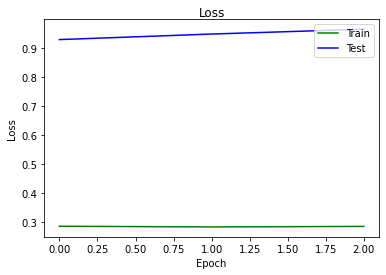

########################   Accuracy  #########################




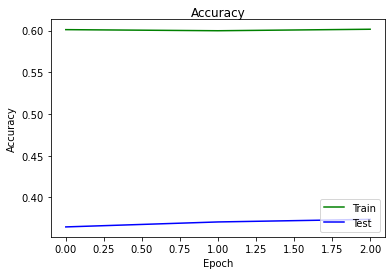

In [60]:
import matplotlib.pyplot as plt

print("Loss\n",history_DNN.history['loss'])
print("Validation Loss\n",history_DNN.history['val_loss'])
print("Accuracy",history_DNN.history['accuracy'])
print("Validation Accuracy",history_DNN.history['val_accuracy'])

#Loss 

print("########################   Loss  #########################\n\n")
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_DNN.history['loss'], color='green')
plt.plot(history_DNN.history['val_loss'], color='blue')
plt.legend(['Train', 'Test'], loc='upper right')
plt.title('Loss', pad=-50)
plt.show()

# Accuracy

print("########################   Accuracy  #########################\n\n")
plt.figure()
plt.plot(history_DNN.history['accuracy'], color='green')
plt.plot(history_DNN.history['val_accuracy'], color='blue')
plt.title('Accuracy', pad=-75)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='lower right')

plt.show()

In [48]:
#Confusion matrix with the evaluation metrics like Precision, Recall and f1Score

print(classification_report(y_test, predicted_output_DNN)) #with Rarest Terms tax2vec for full data and KG = True

              precision    recall  f1-score   support

           0       0.40      0.16      0.23      1692
           1       0.19      0.03      0.05      1226
           2       0.47      0.20      0.29      1150
           3       0.31      0.06      0.09      1069
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00        45

   micro avg       0.38      0.11      0.17      5304
   macro avg       0.23      0.07      0.11      5304
weighted avg       0.34      0.11      0.16      5304
 samples avg       0.11      0.11      0.11      5304



In [185]:
#Confusion matrix with the evaluation metrics like Precision, Recall and f1Score

print(classification_report(y_test, predicted_output_DNN)) #without tax2vec

              precision    recall  f1-score   support

           0       0.42      0.12      0.19      1692
           1       0.18      0.02      0.03      1226
           2       0.46      0.15      0.23      1150
           3       0.27      0.04      0.07      1069
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00        45

   micro avg       0.38      0.08      0.14      5304
   macro avg       0.22      0.05      0.09      5304
weighted avg       0.33      0.08      0.13      5304
 samples avg       0.08      0.08      0.08      5304

